In [4]:
import numpy as np
import EquityOption as bs
import matplotlib.pyplot as plt
import math

class CN:
    def __init__(self, CallFlag='C',Type='E', S0=100, K=100, T=10, vol=0.5, r=0.0001,div=0):
        self.CallFlag=CallFlag
        self.S0=S0
        self.K=K
        self.T=T
        self.vol=vol
        self.r=r
        self.div=div
        self.Type=Type
        
    def OP(self):
        mu = (self.r-self.div-0.5*self.vol*self.vol)
        # range x in [-x_max, x_max]
        x_max = self.vol*np.sqrt(self.T)*5  
        #number of steps along x
        N = 500 
        dx = 2*x_max/N
        # grid along x dimension:
        X = np.linspace(-x_max,x_max,N+1)
        #number of time steps
        J = 500
        dt = self.T/J
        # grid along time dimension:
        d=self.vol*self.vol/(4*dx*dx)-mu/(4*dx)
        c=1/dt-self.r/2-0.5*self.vol*self.vol/(dx*dx)
        cc=1/dt+self.r/2+0.5*self.vol*self.vol/(dx*dx)
        u=self.vol*self.vol/(4*dx*dx)+mu/(4*dx)
        A = cc*np.eye(N+1) -u*np.eye(N+1,k=1) -d*np.eye(N+1,k=-1)
        B = c*np.eye(N+1) + u*np.eye(N+1,k=1) +d*np.eye(N+1,k=-1)
        Ainv = np.linalg.inv(A)
        cut = int(N/4)
        n_mid=int(N/2)
        
        if self.Type=='E':
            if self.CallFlag=='C':
                V = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                for j in range(J):
                    V = Ainv.dot(B).dot(V)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - self.K*np.exp(-self.r*j*dt)
                    if j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])

            else: #European Put
                V = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                for j in range(J):
                    V = Ainv.dot(B).dot(V)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
            
            
        
        else: #American
            if self.CallFlag=='C':
                V0 = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = Ainv.dot(B).dot(V)
                    # apply early exercise boundary conditions: 
                    V = np.where(V<V0, V0, V)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - K*np.exp(-r*j*dt)
                    if j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
                    
                
                    
            else: #American Put
                V0 = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = Ainv.dot(B).dot(V)
                    # apply early exercise boundary conditions: 
                    V = np.where(V<V0, V0, V)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
        return V[n_mid]
        
    
    def Delta(self):
        a=self.OP()
        keep_S0=self.S0
        self.S0=self.S0+1
        b=self.OP()
        self.S0=keep_S0
        return b-a
        
    def Gamma(self):
        a=self.OP()
        keep_S0=self.S0
        self.S0=self.S0+1
        b=self.OP()
        self.S0=self.S0+1
        c=self.OP()
        d1=b-a
        d2=c-b
        self.S0=keep_S0
        return d2-d1
    
    def Theta(self):
        a=self.OP()
        keep_T=self.T
        self.T=self.T-0.001
        b=self.OP()
        self.T=keep_T
        return (b-a)/0.001

European Put Price:
 6.183654271280439 
European Put Delta:
 -0.2577284386028609 
European Put Gamma:
 0.009020879334481258 
European Put Theta:
 -3.6421523429535085
Analytical Solution:
 6.084500786366952 -0.30817362101832424 0.01066312666040876 -3.806892511673439


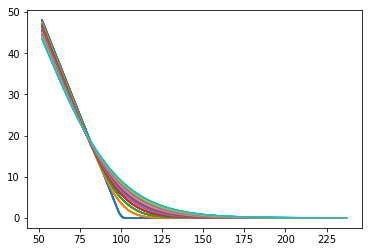

In [5]:
(S0, K, T, vol, r, div) = (110, 100, 1, 0.3, 0.05, 0)
EP=CN(CallFlag='P', Type='E',S0=S0, K=K, T=T, vol=vol, r=r,div=div)
print("European Put Price:\n",EP.OP(),"\nEuropean Put Delta:\n",EP.Delta(),"\nEuropean Put Gamma:\n",EP.Gamma(),"\nEuropean Put Theta:\n",EP.Theta())

BS=bs.EquityOption(CallFlag='P', Spot=S0, Strike=K, Maturity=T, Vol=vol, DividendYield=div,RiskfreeRate=r)
print("Analytical Solution:\n",BS.BS(),BS.Delta(),BS.Gamma(),BS.Theta())

European Call Price:
 3.0392548995928967 
European Cut Delta:
 0.22202689472142234 
European Put Gamma:
 0.010196831726482003 
European Put Theta:
 -0.9467064476704756
Analytical Solution:
 3.0395051124294348 0.21699205911505684 0.010175224445188154 -0.9443743142970722


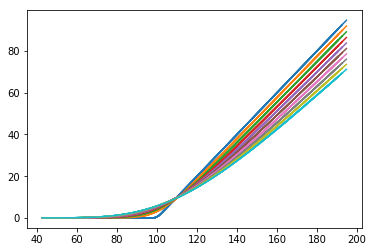

In [15]:
(S0, K, T, vol, r, div) = (90, 100, 1, 0.3, 0.01, 0.15)
EC=CN(CallFlag='C', Type='E',S0=S0, K=K, T=T, vol=vol, r=r,div=div)
print("European Call Price:\n",EC.OP(),"\nEuropean Cut Delta:\n",EC.Delta(),"\nEuropean Put Gamma:\n",EC.Gamma(),"\nEuropean Put Theta:\n",EC.Theta())

BS=bs.EquityOption(CallFlag='C', Spot=S0, Strike=K, Maturity=T, Vol=vol, DividendYield=div,RiskfreeRate=r)
print("Analytical Solution:\n",BS.BS(),BS.Delta(),BS.Gamma(),BS.Theta())


American Put Price:
 6.471104428708375 
American Put Delta:
 -0.274048885972177 
American Put Gamma:
 0.010070808116747543 
American Put Theta:
 -4.0627006106044306


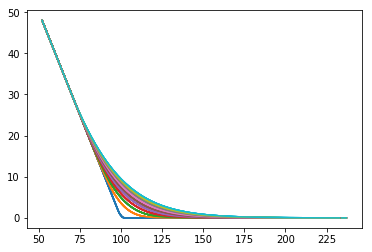

In [16]:
(S0, K, T, vol, r, div) = (110, 100, 1, 0.3, 0.05, 0)
AP=CN(CallFlag='P', Type='A',S0=S0, K=K, T=T, vol=vol, r=r,div=div)
print("American Put Price:\n",AP.OP(),"\nAmerican Put Delta:\n",AP.Delta(),"\nAmerican Put Gamma:\n",AP.Gamma(),"\nAmerican Put Theta:\n",AP.Theta())

American Call Price:
 3.7118601742124673 
American Call Delta:
 0.28765098593316596 
American Call Gamma:
 0.015208610034287418 
American Call Theta:
 -1.8558041925516022


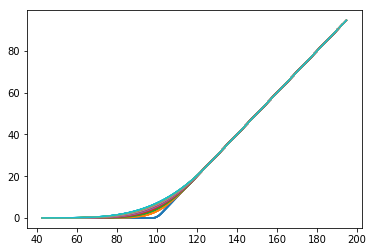

In [17]:
(S0, K, T, vol, r, div) = (90, 100, 1, 0.3, 0.01, 0.15)
AC=CN(CallFlag='C', Type='A',S0=S0, K=K, T=T, vol=vol, r=r,div=div)
print("American Call Price:\n",AC.OP(),"\nAmerican Call Delta:\n",AC.Delta(),"\nAmerican Call Gamma:\n",AC.Gamma(),"\nAmerican Call Theta:\n",AC.Theta())